In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator

from qiskit.quantum_info.operators import Operator, Pauli, SparsePauliOp
from qiskit.converters import circuit_to_instruction
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
from qiskit_ibm_runtime.fake_provider import FakeManilaV2
from qiskit.primitives import StatevectorEstimator

#from qiskit import IBMQ, Aer

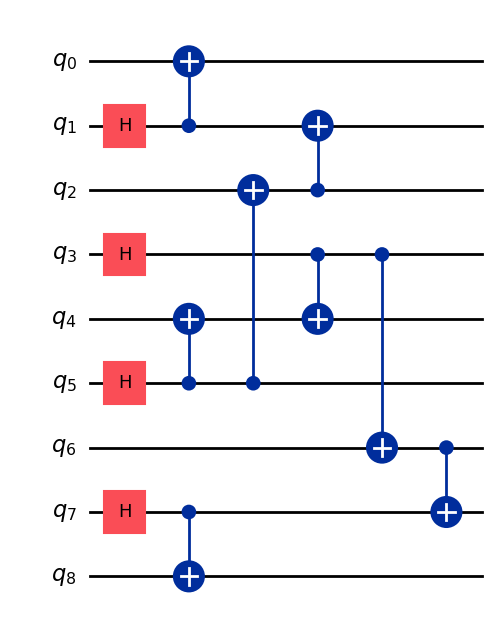

In [2]:
qr = QuantumRegister(9, "q")
#cr = ClassicalRegister(9, "c")
qc = QuantumCircuit(qr)

q0,q1,q2,q3,q4,q5,q6,q7,q8 = qr

qc.h(q1)
qc.h(q3)
qc.h(q5)
qc.h(q7)

qc.cx(q1,q0)
qc.cx(q5,q4)
qc.cx(q7,q8)

qc.cx(q5,q2)

qc.cx(q3,q4)
qc.cx(q2,q1)

qc.cx(q3,q6)

qc.cx(q6,q7)

qc.draw(output="mpl")

In [3]:
def rot_surf_code(n: int) -> QuantumCircuit:
    qr = QuantumRegister(9*n, "q")
    qc = QuantumCircuit(qr)
    list = []
    for i in range(0, 9*n):
        list.append("{:c}".format(i))
    list = qr
    for i in range(n):
        qc.h(list[9*i+1])
        qc.h(list[9*i+3])
        qc.h(list[9*i+5])
        qc.h(list[9*i+7])

        qc.cx(list[9*i+1],list[9*i])
        qc.cx(list[9*i+5],list[9*i+4])
        qc.cx(list[9*i+7],list[9*i+8])

        qc.cx(list[9*i+5],list[9*i+2])

        qc.cx(list[9*i+3],list[9*i+4])
        qc.cx(list[9*i+2],list[9*i+1])

        qc.cx(list[9*i+3],list[9*i+6])

        qc.cx(list[9*i+6],list[9*i+7])
    return qc

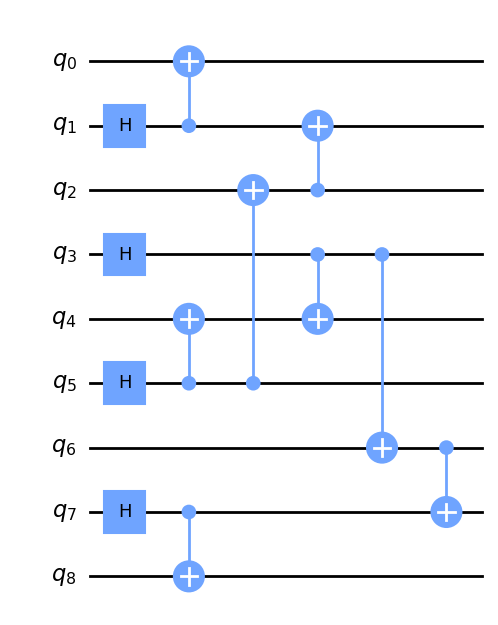

In [4]:
qc = rot_surf_code(1)
qc.draw("mpl", style="clifford")

In [5]:
def logical_operators(qc: QuantumCircuit) -> Operator:                          #Gibt mir X_L und Z_L als Observablen raus, damit ich deren Eigenwert bestimmen kann für den GESAMTEN Circuit
    size = qc.num_qubits
    n = int(size/9)
    string_x = ""
    string_z = ""
    for i in range(n):
        string_x += "IXIIXIIXI"
        string_z += "IIIZZZIII"
    logical_x = SparsePauliOp.from_list([(string_x,1.0)])                           #Zahl "1.0" ist nur ein Vorfaktor
    logical_z = SparsePauliOp.from_list([(string_z,1.0)])
    return logical_x, logical_z

def logical_operators_first_qubit(qc: QuantumCircuit) -> Operator:              #Gibt mir X_L und Z_L nur für den ersten logical qubit!!!
    string_x = "IXIIXIIXI"
    string_z = "IIIZZZIII"
    size = qc.num_qubits
    n = int(size/9)
    for i in range(n-1):
        string_x += "IIIIIIIII"
        string_z += "IIIIIIIII"
    logical_x = SparsePauliOp.from_list([(string_x,1.0)])                           #Zahl "1.0" ist nur ein Vorfaktor
    logical_z = SparsePauliOp.from_list([(string_z,1.0)])
    return logical_x, logical_z

def estimate_observables(circuit: QuantumCircuit, observables: list):
    estimator = StatevectorEstimator()
    pub = (circuit, observables)
    job = estimator.run([pub])
    result = job.result()[0]
    return result

def X_L(circuit: QuantumCircuit, n=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will X_L auf den ersten anwenden ---> n = 0 !!!
    if type(n) == int:
        circuit.x(9*n+1)
        circuit.x(9*n+4)
        circuit.x(9*n+7)
    elif type(n) == list:
        for i in n:
            circuit.x(9*i+1)
            circuit.x(9*i+4)
            circuit.x(9*i+7)
    return circuit


def Z_L(circuit: QuantumCircuit, n=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will Z_L auf den ersten anwenden ---> n = 0 !!!
    if type(n) == int:
        circuit.z(9*n+3)
        circuit.z(9*n+4)
        circuit.z(9*n+5)
    elif type(n) == list:
        for i in n:
            circuit.z(9*i+3)
            circuit.z(9*i+4)
            circuit.z(9*i+5)
    return circuit


In [6]:
qc = rot_surf_code(1)

x_l, z_l = logical_operators(qc)

qc = X_L(qc)

psi = circuit_to_instruction(qc)

result = estimate_observables(qc, [x_l,z_l])
print("Erwartungswert von X_L : ",result.data.evs[0])
print("Erwartungswert von Z_L : ",result.data.evs[1])
#result.data.stds
# for idx, pauli in enumerate([x_l,z_l]):
#     plt.plot(result.data.evs[idx], label=pauli)
# plt.legend()

Erwartungswert von X_L :  0.0
Erwartungswert von Z_L :  -0.9999999999999992


In [7]:
qc = rot_surf_code(2)

x_l, z_l = logical_operators_first_qubit(qc)

#qc = X_L(qc,[0,1])

qc.x(1)
qc.x(4)
qc.x(7)

#qc.x(10)
#qc.x(13)
#qc.x(16)

psi = circuit_to_instruction(qc)

result = estimate_observables(qc, [x_l,z_l])
print("Erwartungswert von X_L : ",result.data.evs[0])
print("Erwartungswert von Z_L : ",result.data.evs[1])
#result.data.stds
# for idx, pauli in enumerate([x_l,z_l]):
#     plt.plot(result.data.evs[idx], label=pauli)
# plt.legend()

Erwartungswert von X_L :  0.0
Erwartungswert von Z_L :  0.9999999999999998


In [8]:
qc = rot_surf_code(1)

x_l, z_l = logical_operators(qc)

for i in range(qc.num_qubits):
    qc.h(i)

psi = circuit_to_instruction(qc)

result = estimate_observables(qc, [x_l,z_l])
print("Erwartungswert von X_L : ",result.data.evs[0])
print("Erwartungswert von Z_L : ",result.data.evs[1])
#result.data.stds
# for idx, pauli in enumerate([x_l,z_l]):
#     plt.plot(result.data.evs[idx], label=pauli)
# plt.legend()

Erwartungswert von X_L :  5.964210281990185e-50
Erwartungswert von Z_L :  6.938893903907228e-18
